In [1]:
!uv pip install -q --system numba-cuda==0.4.0
import numba.cuda as cuda
from numba import config, float32
config.CUDA_ENABLE_PYNVJITLINK = 1
import matplotlib.pyplot as plt
import time
import numpy as np

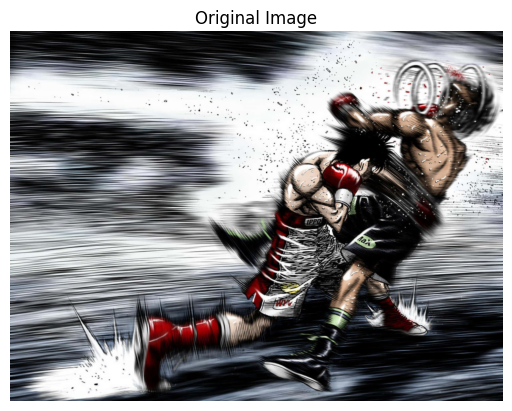

In [2]:
img = plt.imread('ippo.jpg')
plt.imshow(img)
plt.axis('off')
plt.title('Original Image')
plt.show()

In [3]:
print(img.shape)
compressed_img = img.reshape(img.shape[0]* img.shape[1], 3)
print(compressed_img.shape)

(1440, 1920, 3)
(2764800, 3)


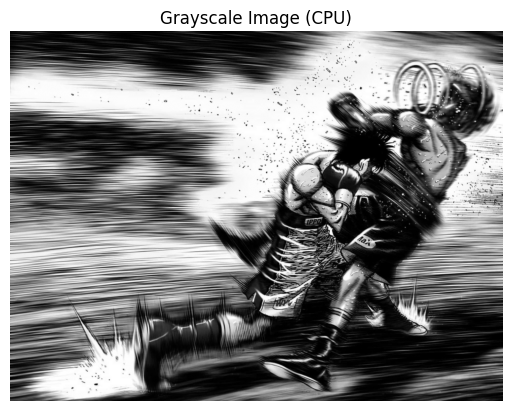

CPU grayscale time: 4.435725 s


In [4]:
def grayscale_cpu(rgb):
    gray = np.zeros(rgb.shape[0], dtype=np.float32)
    for i in range(rgb.shape[0]):
        r, g, b = rgb[i]
        gray[i] = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

if img.dtype == np.uint8:
    img = img.astype(np.float32) / 255

h, w, c = img.shape
pixels = h * w

rgb_flat = img.reshape(pixels, 3)

t0 = time.time()
gray_img = grayscale_cpu(rgb_flat)
t1 = time.time()

gray_img = gray_img.reshape(h, w)

plt.imshow(gray_img, cmap='gray')
plt.axis('off')
plt.title('Grayscale Image (CPU)')
plt.show()

print(f"CPU grayscale time: {t1 - t0:.6f} s")

In [5]:
compressed_img = cuda.to_device(compressed_img)
block_size = 64
pixel_count = img.shape[0] * img.shape[1]
grid_size = int(pixel_count/block_size)

GPU runtime: 0.858737


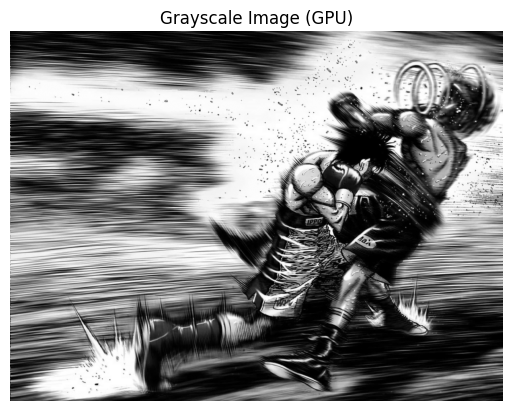

In [6]:
@cuda.jit
def grayscale_gpu(src, dst):
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  g = np.uint8((src[tidx, 0] + src[tidx, 1] + src[tidx, 2]) / 3)
  dst[tidx, 0] = dst[tidx, 1] = dst[tidx, 2] = g

gray_img_cuda =  cuda.device_array((pixel_count, 1), dtype=np.uint8)
start = time.time()
grayscale_gpu[grid_size, block_size](compressed_img, gray_img_cuda)
end = time.time()

gray_img = gray_img_cuda.copy_to_host()
gray_img = gray_img.reshape(img.shape[0], img.shape[1], 1)
plt.title('Grayscale Image (GPU)')
plt.axis('off')
plt.imshow(gray_img, cmap="gray")
print(f"GPU runtime: {end - start:.6f}")

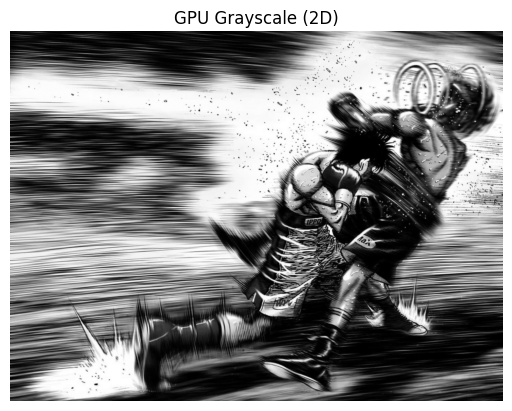

GPU runtime: 0.000298 s


In [7]:
@cuda.jit
def grayscale_gpu_2d(src, dst, width, height):
    x, y = cuda.grid(2)
    if x < width and y < height:
        r = src[y, x, 0]
        g = src[y, x, 1]
        b = src[y, x, 2]
        gray = (int(r) + int(g) + int(b)) // 3
        dst[y, x] = gray

if img.dtype != np.uint8:
    img = (img * 255).astype(np.uint8)

height, width = img.shape[0], img.shape[1]

src_device = cuda.to_device(img)
dst_device = cuda.device_array((height, width), dtype=np.uint8)

threads_per_block = (16, 16)
blocks_per_grid_x = int(np.ceil(width / threads_per_block[0]))
blocks_per_grid_y = int(np.ceil(height / threads_per_block[1]))
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

grayscale_gpu_2d[blocks_per_grid, threads_per_block](src_device, dst_device, width, height)
cuda.synchronize()

start_gpu = time.time()
grayscale_gpu_2d[blocks_per_grid, threads_per_block](src_device, dst_device, width, height)
cuda.synchronize()
end_gpu = time.time()
gpu_time = end_gpu - start_gpu

gray_gpu = dst_device.copy_to_host()

plt.imshow(gray_gpu, cmap='gray')
plt.title(f"GPU Grayscale (2D)")
plt.axis('off')

plt.show()

print(f"GPU runtime: {gpu_time:.6f} s")

In [8]:
gaussian_kernel = np.array([
    [0, 0, 1, 2, 1, 0, 0],
    [0, 3, 13, 22, 13, 3, 0],
    [1, 13, 59, 97, 59, 13, 1],
    [2, 22, 97, 159, 97, 22, 2],
    [1, 13, 59, 97, 59, 13, 1],
    [0, 3, 13, 22, 13, 3, 0],
    [0, 0, 1, 2, 1, 0, 0]
], dtype=np.float32)
gaussian_kernel /= np.sum(gaussian_kernel)


In [9]:
@cuda.jit
def gaussian_blur_no_shared(input_img, output_img, kernel):
    x, y = cuda.grid(2)
    height, width = input_img.shape[:2]
    k = kernel.shape[0] // 2
    if x < width and y < height:
        acc = 0.0
        for i in range(-k, k+1):
            for j in range(-k, k+1):
                xi = min(max(x + i, 0), width - 1)
                yj = min(max(y + j, 0), height - 1)
                acc += input_img[yj, xi] * kernel[j + k, i + k]
        output_img[y, x] = acc


In [10]:
@cuda.jit
def gaussian_blur_shared(input_img, output_img, kernel):
    shared_kernel = cuda.shared.array(shape=(7,7), dtype=float32)
    tx, ty = cuda.threadIdx.x, cuda.threadIdx.y
    bx, by = cuda.blockIdx.x, cuda.blockIdx.y
    bw, bh = cuda.blockDim.x, cuda.blockDim.y
    x, y = bx * bw + tx, by * bh + ty

    if tx < 7 and ty < 7:
        shared_kernel[ty, tx] = kernel[ty, tx]
    cuda.syncthreads()

    height, width = input_img.shape[:2]
    k = 3
    if x < width and y < height:
        acc = 0.0
        for i in range(-k, k+1):
            for j in range(-k, k+1):
                xi = min(max(x + i, 0), width - 1)
                yj = min(max(y + j, 0), height - 1)
                acc += input_img[yj, xi] * shared_kernel[j + k, i + k]
        output_img[y, x] = acc


In [14]:
img = np.random.rand(512, 512).astype(np.float32)
output_no_shared = np.zeros_like(img)
output_shared = np.zeros_like(img)

threadsperblock = (16, 16)
blockspergrid_x = int(np.ceil(img.shape[1] / threadsperblock[0]))
blockspergrid_y = int(np.ceil(img.shape[0] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

start = time.time()
gaussian_blur_no_shared[blockspergrid, threadsperblock](img, output_no_shared, gaussian_kernel)
cuda.synchronize()
t_no_shared = time.time() - start

start = time.time()
gaussian_blur_shared[blockspergrid, threadsperblock](img, output_shared, gaussian_kernel)
cuda.synchronize()
t_shared = time.time() - start

print(f"No Shared Memory: {t_no_shared:.5f}s")
print(f"With Shared Memory: {t_shared:.5f}s")
print(f"Speedup: {t_no_shared / t_shared:.2f}x")

No Shared Memory: 0.00524s
With Shared Memory: 0.00417s
Speedup: 1.26x
